Набор данных для дальнейшего построения классификатора был взят из соревнования 2015 года по машинному обучению "_Twitter US Airline Sentiment_" на сайте _Kaggle_.
https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [163]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import sparse
from numpy import interp
from itertools import cycle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import re
from vecstack import stacking
from sklearn.utils import shuffle

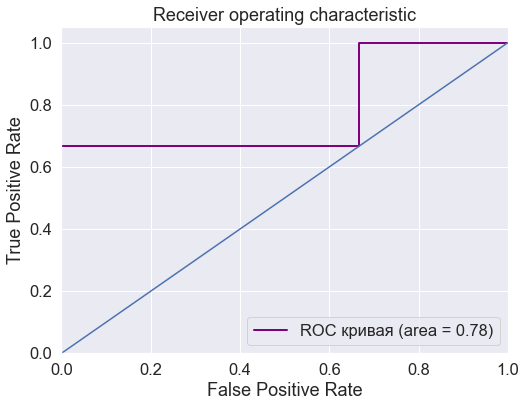

0.7777777777777778


In [53]:
y_true = [0, 1, 0, 0, 1, 1]
predicts = [0.13, 0.33, 0.39, 0.59, 0.75, 0.95]
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_true, predicts, pos_label=1)
lw = 2
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=lw, color='purple',
         label='ROC кривая (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("ROC.png")
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print(roc_auc)

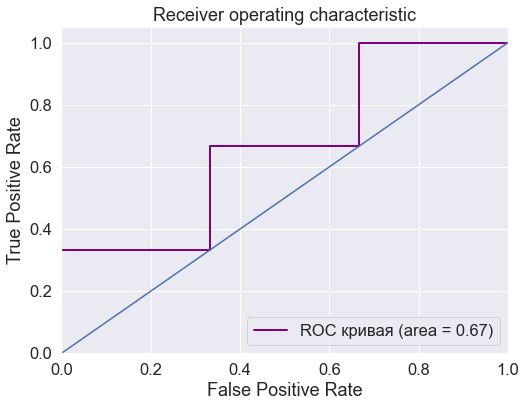

0.6666666666666667


In [54]:
y_true = [0, 1, 0, 1, 0, 1]
predicts = [0.13, 0.33, 0.39, 0.75, 0.79, 0.95]
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_true, predicts, pos_label=1)
lw = 2
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=lw, color='purple',
         label='ROC кривая (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("ROC.png")
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print(roc_auc)

In [55]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [56]:
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [57]:
tweets = pd.read_csv('Tweets.csv')

In [58]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [59]:
tweets.shape

(14640, 15)

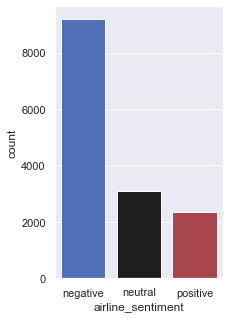

In [60]:
plt.figure(figsize=(3,5))
sns.set_theme(style="darkgrid")
sns.countplot(x='airline_sentiment', data=tweets, palette= 'icefire', order = ['negative', 'neutral', 'positive'])
plt.show()

In [61]:
tweets.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [62]:
enc = LabelEncoder()
y = enc.fit_transform(tweets['airline_sentiment'])
tweets['airline_sentiment'] = y

In [64]:
enc.inverse_transform([0, 1, 2, 2])

array(['negative', 'neutral', 'positive', 'positive'], dtype=object)

In [65]:
enc.inverse_transform([0])[0]

'negative'

In [66]:
tweets['airline_sentiment']

0        1
1        2
2        1
3        0
4        0
        ..
14635    2
14636    0
14637    1
14638    0
14639    1
Name: airline_sentiment, Length: 14640, dtype: int64

In [68]:
dataframe = shuffle(tweets, random_state=77)
X_train = dataframe[:int(len(dataframe)*0.80)]
X_test = dataframe[len(X_train):]

In [69]:
X_train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
13667,569761641211895808,0,1.0,Cancelled Flight,0.6639,American,NaN,krlmnz,NaN,0,@AmericanAir My connecting flight to DFW was Cancelled Flightled and need to get to IND tomorrow. Any way I can get this sorted out? Been holding 1h08,NaN,2015-02-22 23:32:15 -0800,New York City,Eastern Time (US & Canada)
3837,568090851907207169,0,1.0,Lost Luggage,1.0000,United,NaN,c9n0thing,NaN,0,@united my bag is a few days Late Flight to me and this is like the 3rd time in the past couple months. Where my free miles at?!,NaN,2015-02-18 08:53:08 -0800,San Diego,Pacific Time (US & Canada)
10171,569507677501595649,1,1.0,NaN,NaN,US Airways,NaN,nanceebing,NaN,0,@USAirways but need to confirm please help,NaN,2015-02-22 06:43:05 -0800,south beach/ LA / NC,Eastern Time (US & Canada)
9817,569652631938985984,0,1.0,Customer Service Issue,1.0000,US Airways,NaN,mjkelesh,NaN,0,@USAirways your IVR hung up on me because of high call volume? I need help. Call me,NaN,2015-02-22 16:19:05 -0800,O-H,NaN
7213,569884948091396096,2,1.0,NaN,NaN,Delta,NaN,DaddyFiles,NaN,0,@JetBlue Haha. Thanks. You guys are great. Unlike the @nyjets. ;-) #GoPatriots!,NaN,2015-02-23 07:42:14 -0800,Massachusetts,Eastern Time (US & Canada)


In [70]:
X_test.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11771,567768417038761987,1,1.0000,NaN,NaN,US Airways,NaN,JenniesMagic,NaN,0,@USAirways done,NaN,2015-02-17 11:31:53 -0800,NaN,Eastern Time (US & Canada)
3261,568564757172764672,0,1.0000,Customer Service Issue,1.0000,United,NaN,fatabdula,NaN,0,@united And there is no direct phone number for status match desk? I really regret Flight Booking Problems with @united now.,NaN,2015-02-19 16:16:16 -0800,NaN,Eastern Time (US & Canada)
4339,570302030742470658,1,0.6825,NaN,NaN,Southwest,NaN,HaleyOstrander,NaN,0,@SouthwestAir once again on Glassdoor's Best Places To Work snagging # 15 overall #notsurprising #LUVthem,NaN,2015-02-24 11:19:34 -0800,TX,NaN
10397,569332237138841600,2,0.3502,NaN,0.0000,US Airways,NaN,MattClement,NaN,0,@USAirways Oh well. I'll get to Cancun eventually.,NaN,2015-02-21 19:05:57 -0800,"Troy, NY",Eastern Time (US & Canada)
6393,567887103465496576,0,1.0000,Late Flight,0.6285,Southwest,NaN,Lionheart_Lisa,NaN,0,"@SouthwestAir Tried to leave Monday, all other planes left but mine. Now this one keeps getting delayed. Missed work. Have to pay for a cab",NaN,2015-02-17 19:23:30 -0800,Hanging with Carmen Sandiego.,Central Time (US & Canada)


In [71]:
collist = ['airline_sentiment', 'text']
X_train = X_train[collist]
X_test = X_test[collist]

In [72]:
X_train = X_train.reset_index()

In [73]:
X_test = X_test.reset_index()

In [74]:
X_train.head(10)

,index,airline_sentiment,text
0,13667,0,@AmericanAir My connecting flight to DFW was Cancelled Flightled and need to get to IND tomorrow. Any way I can get this sorted out? Been holding 1h08
1,3837,0,@united my bag is a few days Late Flight to me and this is like the 3rd time in the past couple months. Where my free miles at?!
2,10171,1,@USAirways but need to confirm please help
3,9817,0,@USAirways your IVR hung up on me because of high call volume? I need help. Call me
4,7213,2,@JetBlue Haha. Thanks. You guys are great. Unlike the @nyjets. ;-) #GoPatriots!
5,9073,0,@USAirways So frustrating because I still have not gotten them back. Why my bag was sent to NY is a mystery! Shame on me this time!
6,8055,1,@JetBlue I'm looking every day just watching for a deal. I have specific dates so fare finder doesn't help me
7,9614,0,@USAirways forced sections 4 and 5 to check their carry on. would have packed differently to check my bag. Why even allow it? #pissed
8,2141,0,@united the drunk guy you threw out of flight UA936 4hrs ago is better off than the rest of us held up for 5hrs in the plane without food.
9,3903,0,@united my baggage is in shannon now so never mind u can work on giving me some $$$ back now


In [75]:
X_train.shape

(11712, 3)

In [76]:
X_test.shape

(2928, 3)

### 1. Модель Мешок Слов

In [77]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train['text'])
X.shape

(11712, 13309)

In [78]:
pipeline = Pipeline([('vect', CountVectorizer()),
               ('xgb', XGBClassifier(eval_metric = 'mlogloss'))])

In [79]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

cv_pred = cross_validate(pipeline, X_train['text'], X_train['airline_sentiment'],
                             cv=cv, scoring=('roc_auc_ovr', 'accuracy'))

In [80]:
cv_pred

{'fit_time': array([2.32947731, 2.07004499, 2.07717204, 2.11390877, 2.37530923]),
 'score_time': array([0.15037894, 0.15305591, 0.14592004, 0.1739583 , 0.17542291]),
 'test_roc_auc_ovr': array([0.8951771 , 0.89672368, 0.90035115, 0.89207251, 0.9071303 ]),
 'test_accuracy': array([0.78233035, 0.78489117, 0.7882152 , 0.77882152, 0.79205807])}

In [81]:
print('Xgb: \n', 'Accuracy =', cv_pred['test_accuracy'].mean(),
      '\n', 'Roc-Auc = ', cv_pred['test_roc_auc_ovr'].mean(), '\n')

Xgb: 
 Accuracy = 0.7852632603321192 
 Roc-Auc =  0.8982909478070626 



### 2. Удаление неинформативного контента

In [82]:
def standardize_text(df, text_field):
    df2 = df.copy()
    df2[text_field] = df2[text_field].str.replace(r"http\S+", "") #после http ищет один или несколько не пробельных символов          
    df2[text_field] = df2[text_field].str.replace(r"[^a-zA-Z]", " ") # удаление ненужных символов из всех твитов
    df2[text_field] = df2[text_field].str.lower() #приведём все буквы в словах к нижнему регистру
    return df2

In [83]:
X_train1 = standardize_text(X_train, "text")
X_test1 = standardize_text(X_test, "text")

X_train1.to_csv("train_clean_data_for_practice.csv")
X_test1.to_csv("test_clean_data_for_practice.csv")

X_train1.head(20)

,index,airline_sentiment,text
0,13667,0,americanair my connecting flight to dfw was cancelled flightled and need to get to ind tomorrow any way i can get this sorted out been holding h
1,3837,0,united my bag is a few days late flight to me and this is like the rd time in the past couple months where my free miles at
2,10171,1,usairways but need to confirm please help
3,9817,0,usairways your ivr hung up on me because of high call volume i need help call me
4,7213,2,jetblue haha thanks you guys are great unlike the nyjets gopatriots
5,9073,0,usairways so frustrating because i still have not gotten them back why my bag was sent to ny is a mystery shame on me this time
6,8055,1,jetblue i m looking every day just watching for a deal i have specific dates so fare finder doesn t help me
7,9614,0,usairways forced sections and to check their carry on would have packed differently to check my bag why even allow it pissed
8,2141,0,united the drunk guy you threw out of flight ua hrs ago is better off than the rest of us held up for hrs in the plane without food
9,3903,0,united my baggage is in shannon now so never mind u can work on giving me some back now


In [84]:
pipeline = Pipeline([('vect', CountVectorizer()),
               ('xgb', XGBClassifier(eval_metric = 'mlogloss'))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

cv_pred = cross_validate(pipeline, X_train1['text'],
                            X_train1['airline_sentiment'],
                            cv=cv, scoring=('roc_auc_ovr', 'accuracy'))

print('Xgb: \n', 'Accuracy =', cv_pred['test_accuracy'].mean(),
      '\n', 'Roc-Auc = ', cv_pred['test_roc_auc_ovr'].mean(), '\n') 

Xgb: 
 Accuracy = 0.783214604762337 
 Roc-Auc =  0.89793645606695 



### 3. Лемматизация

In [85]:
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize("wanted", 'v')

'want'

In [90]:
pd.options.mode.chained_assignment = None  # default='warn'

In [91]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemmatization(df, text_field):
    dataframe = df.copy()
    for i in range(len(dataframe)):
        dataframe[text_field][i] = [lemmatizer.lemmatize(w, get_wordnet_pos(w))
                                    for w in nltk.word_tokenize(df[text_field][i])]
        dataframe[text_field][i] = ' '.join(word for word in dataframe[text_field][i]) 
    return dataframe

X_train2 = lemmatization(X_train1, 'text')
X_train2.head(15)

,index,airline_sentiment,text
0,13667,0,americanair my connect flight to dfw be cancel flightled and need to get to ind tomorrow any way i can get this sort out be hold h
1,3837,0,united my bag be a few day late flight to me and this be like the rd time in the past couple month where my free mile at
2,10171,1,usairways but need to confirm please help
3,9817,0,usairways your ivr hung up on me because of high call volume i need help call me
4,7213,2,jetblue haha thanks you guy be great unlike the nyjets gopatriots
5,9073,0,usairways so frustrate because i still have not gotten them back why my bag be sent to ny be a mystery shame on me this time
6,8055,1,jetblue i m look every day just watch for a deal i have specific date so fare finder doesn t help me
7,9614,0,usairways force section and to check their carry on would have packed differently to check my bag why even allow it piss
8,2141,0,united the drunk guy you threw out of flight ua hr ago be well off than the rest of u held up for hr in the plane without food
9,3903,0,united my baggage be in shannon now so never mind u can work on give me some back now


In [92]:
X_test2 = lemmatization(X_test1, 'text')

In [93]:
pipeline = Pipeline([('vect', CountVectorizer()),
               ('xgb', XGBClassifier(eval_metric = 'mlogloss'))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

cv_pred = cross_validate(pipeline, X_train2['text'],
                            X_train2['airline_sentiment'],
                            cv=cv, scoring=('roc_auc_ovr', 'accuracy'))

print('Xgb: \n', 'Accuracy =', cv_pred['test_accuracy'].mean(),
      '\n', 'Roc-Auc = ', cv_pred['test_roc_auc_ovr'].mean(), '\n') 

Xgb: 
 Accuracy = 0.7914107578472934 
 Roc-Auc =  0.899249036591606 



In [94]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train2['text'])
X.shape

(11712, 9019)

### 4. N-граммы

In [242]:
pipeline = Pipeline([('vect', CountVectorizer()),
               ('xgb', XGBClassifier(eval_metric = 'mlogloss'))])

In [243]:
param_test_for_search = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)] }

In [247]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=3, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='mlogloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_const

In [248]:
hyper_search.best_params_ 

{'vect__ngram_range': (1, 3)}

In [249]:
hyper_search.best_score_ 

0.901873925443255

In [323]:
vectorizer = CountVectorizer(ngram_range = (1, 3))
X = vectorizer.fit_transform(X_train2['text'])
X.shape

(11712, 213480)

### 6. Стоп слова 

In [250]:
pipeline = Pipeline([('vect', CountVectorizer(stop_words='english')),
               ('xgb', XGBClassifier(eval_metric = 'mlogloss'))])

param_test_for_search = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)] }
    #'vect__max_df':[1.0], 
    #'vect__min_df':[0.0005],  # 0.0005
    #'vect__use_idf': [False, True] }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=6, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(stop_words='english')),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='mlogloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
           

In [251]:
hyper_search.best_params_ 

{'vect__ngram_range': (1, 2)}

In [252]:
hyper_search.best_score_

0.8794433062702801

In [324]:
vectorizer = CountVectorizer(ngram_range = (1, 3), stop_words='english')
X = vectorizer.fit_transform(X_train2['text'])
X.shape

(11712, 140491)

### 5. TF-IDF

In [253]:
pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tf', TfidfTransformer()),
               ('xgb', XGBClassifier(eval_metric = 'mlogloss'))])

param_test_for_search = {
    'vect__ngram_range': [(1, 2), (1, 1), (1, 3)],
    #'vect__max_df':[1.0], 
    #'vect__min_df':[0.0005],  # 0.0005
    'tf__use_idf': [False, True] }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=6, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('tf', TfidfTransformer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='mlogloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
    

In [254]:
hyper_search.best_params_ 

{'vect__ngram_range': (1, 2), 'tf__use_idf': False}

In [255]:
hyper_search.best_score_

0.8972360674161252

### Min_df и Max_df (снижение размерности)

In [268]:
pipeline = Pipeline([('vect', CountVectorizer()),
               ('xgb', XGBClassifier(eval_metric = 'mlogloss'))])

param_test_for_search = {
    'vect__ngram_range': [(1, 3)],
    'vect__max_df':[0.17], 
    'vect__min_df': [0.0001]}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=10, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='mlogloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_const

In [269]:
hyper_search.best_params_ 

{'vect__ngram_range': (1, 3), 'vect__min_df': 0.0001, 'vect__max_df': 0.17}

In [270]:
hyper_search.best_score_  # 0.90192

0.9019241204787996

In [347]:
vectorizer = CountVectorizer(ngram_range = (1, 3), max_df = 0.17, min_df = 0.0001) # min_df = 0.00001 !
X = vectorizer.fit_transform(X_train2['text'])
X.shape

(11712, 37578)

In [122]:
X_test2['airline_sentiment'][:20]

0     1
1     0
2     1
3     2
4     0
5     0
6     0
7     0
8     0
9     1
10    0
11    2
12    0
13    2
14    0
15    2
16    0
17    2
18    0
19    0
Name: airline_sentiment, dtype: int64

In [134]:
io = X_test2['airline_sentiment'] 
y_testt = label_binarize(io, classes=[0, 1, 2])
n_clas = y_testt.shape[1]
y_testt[20:30]

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [133]:
y_pred_prob_svm[20:30].round(3)

array([[0.44 , 0.302, 0.258],
       [0.157, 0.722, 0.122],
       [0.997, 0.002, 0.001],
       [0.962, 0.024, 0.014],
       [0.852, 0.125, 0.023],
       [0.504, 0.001, 0.495],
       [0.844, 0.034, 0.122],
       [0.975, 0.011, 0.014],
       [0.469, 0.478, 0.053],
       [0.452, 0.524, 0.024]])

# Function for building ROC-AUC (micro/macro)

In [95]:
def multiclass_roc_auc(y, y_score, s, parameter):
    # y - истинные ответы
    # y_score - вероятности принадлежности классам / ответы модели
    # s - название модели
    # parameter = 'plot' если нарисовать, = 'info' если нужны только значения 
    
    y_test = label_binarize(y, classes=[0, 1, 2])
    n_classes = y_test.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    if(parameter == 'plot'):
        plt.figure(figsize=(9, 6))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.4f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.4f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.4f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Roc-Auc for %s' % s)
        plt.legend(loc="lower right")
        plt.show()
        
    if(parameter == 'info'):
        print('%s' % s)
        for i in range(n_classes):
            print('Roc-Auc for Class %i : ' % i, roc_auc[i])
        print('Micro-Average : ', roc_auc['micro'], '\n')
        print('Macro-Average : ', roc_auc['macro'])
        

# Function to build confusion matrix

In [166]:
def build_confusion_matrix(model, X_test_text, y_test):
    class_names = np.array(['Negative', 'Neutral', 'Positive'])
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:

        disp = plot_confusion_matrix(model, X_test_text, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        plt.grid(False)
        print(title)
        print(disp.confusion_matrix)

    plt.show()

# MultinomialNB

In [96]:
pipeline = Pipeline([('vect', CountVectorizer()),
               ('nb', MultinomialNB())])

param_test_for_search = {
    'vect__ngram_range': [(1, 2)],
    'vect__max_df':[0.15], 
    'vect__min_df': [0.00016, 0]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=30, scoring=('roc_auc_ovr', 'accuracy'), 
                                  cv=cv, n_jobs=-1, refit='roc_auc_ovr', random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('nb', MultinomialNB())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'vect__max_df': [0.15],
                                        'vect__min_df': [0.00016, 0],
                                        'vect__ngram_range': [(1, 2)]},
                   random_state=77, refit='roc_auc_ovr',
                   scoring=('roc_auc_ovr', 'accuracy'), verbose=2)

In [97]:
print(hyper_search.best_params_ )
print(hyper_search.best_score_) 

{'vect__ngram_range': (1, 2), 'vect__min_df': 0.00016, 'vect__max_df': 0.15}
0.905746075689212


In [98]:
hyper_search.cv_results_

{'mean_fit_time': array([0.69425001, 0.68243899]),
 'std_fit_time': array([0.00371996, 0.17556817]),
 'mean_score_time': array([0.23565073, 0.19842782]),
 'std_score_time': array([0.00400678, 0.03772739]),
 'param_vect__ngram_range': masked_array(data=[(1, 2), (1, 2)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_vect__min_df': masked_array(data=[0.00016, 0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_vect__max_df': masked_array(data=[0.15, 0.15],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'vect__ngram_range': (1, 2),
   'vect__min_df': 0.00016,
   'vect__max_df': 0.15},
  {'vect__ngram_range': (1, 2), 'vect__min_df': 0, 'vect__max_df': 0.15}],
 'split0_test_roc_auc_ovr': array([0.90023015, 0.88999337]),
 'split1_test_roc_auc_ovr': array([0.90828637, 0.89307267]),
 'split2_test_roc_auc_ovr': array([0.90571838, 0.89636509]),
 'spl

In [99]:
model_nb = hyper_search.best_estimator_ 

In [101]:
y_pred_prob_nb = model_nb.predict_proba(X_test2['text'])

In [104]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_nb, 'Naive Bayes', 'info')

Naive Bayes
Roc-Auc for Class 0 :  0.9148231848998949
Roc-Auc for Class 1 :  0.8837148790276627
Roc-Auc for Class 2 :  0.9328628179832288
Micro-Average :  0.9345117869860252 

Macro-Average :  0.9107147328795852


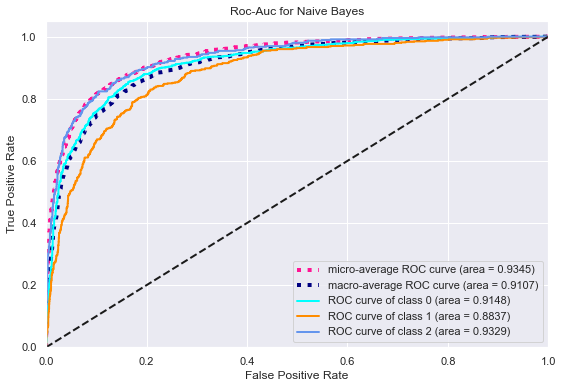

In [105]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_nb, 'Naive Bayes', 'plot')

In [110]:
y_pred_nb = model_nb.predict(X_test2['text'])
accuracy_score(X_test2['airline_sentiment'], y_pred_nb)

0.807035519125683

Confusion matrix, without normalization
[[1728   90   51]
 [ 228  314   57]
 [ 100   39  321]]
Normalized confusion matrix
[[0.92 0.05 0.03]
 [0.38 0.52 0.1 ]
 [0.22 0.08 0.7 ]]


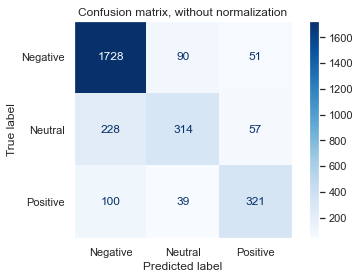

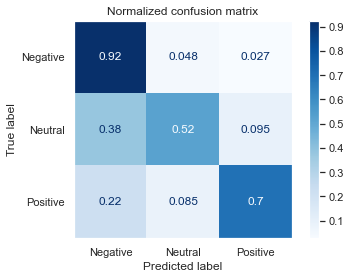

In [165]:
build_confusion_matrix(model_nb, X_test2['text'], X_test2['airline_sentiment'])

# Support Vector Machines

In [106]:
pipeline = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2))),
               ('svm', svm.SVC(kernel = 'sigmoid', probability=True))])

param_test_for_search = {
    'vect__max_df':[0.15], 
    'vect__min_df': [0.00012]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=10, scoring=('roc_auc_ovr','accuracy'), 
                                  cv=cv, n_jobs=-1, refit='roc_auc_ovr', random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('svm',
                                              SVC(kernel='sigmoid',
                                                  probability=True))]),
                   n_jobs=-1,
                   param_distributions={'vect__max_df': [0.15],
                                        'vect__min_df': [0.00012]},
                   random_state=77, refit='roc_auc_ovr',
                   scoring=('roc_auc_ovr', 'accuracy'), verbose=2)

In [107]:
print(hyper_search.best_params_ )
print(hyper_search.best_score_) 

{'vect__min_df': 0.00012, 'vect__max_df': 0.15}
0.9060773216318522


In [108]:
hyper_search.cv_results_

{'mean_fit_time': array([58.7946104]),
 'std_fit_time': array([0.3494253]),
 'mean_score_time': array([4.19301324]),
 'std_score_time': array([0.04853851]),
 'param_vect__min_df': masked_array(data=[0.00012],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_vect__max_df': masked_array(data=[0.15],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'vect__min_df': 0.00012, 'vect__max_df': 0.15}],
 'split0_test_roc_auc_ovr': array([0.9016181]),
 'split1_test_roc_auc_ovr': array([0.90484071]),
 'split2_test_roc_auc_ovr': array([0.90776806]),
 'split3_test_roc_auc_ovr': array([0.90157225]),
 'split4_test_roc_auc_ovr': array([0.91458749]),
 'mean_test_roc_auc_ovr': array([0.90607732]),
 'std_test_roc_auc_ovr': array([0.00483717]),
 'rank_test_roc_auc_ovr': array([1], dtype=int32),
 'split0_test_accuracy': array([0.78787879]),
 'split1_test_accuracy': array([0.79641485]),
 'split2_test_accuracy': array([0.804867

In [111]:
model_svm = hyper_search.best_estimator_ 

In [112]:
y_pred_prob_svm = model_svm.predict_proba(X_test2['text'])

In [115]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_svm, 'Support Vector Machines', 'info')

Support Vector Machines
Roc-Auc for Class 0 :  0.913227900575515
Roc-Auc for Class 1 :  0.8807580402717856
Roc-Auc for Class 2 :  0.9333384715664856
Micro-Average :  0.9356919786161128 

Macro-Average :  0.909346732561762


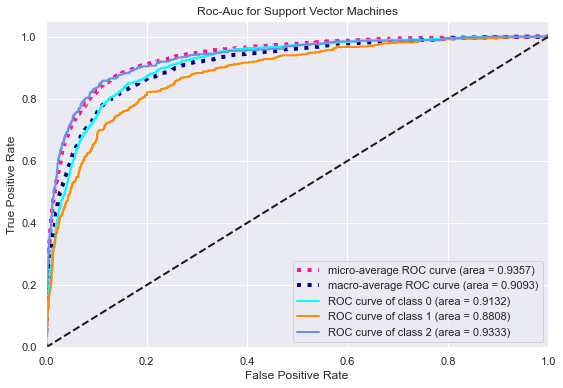

In [113]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_svm, 'Support Vector Machines', 'plot')

In [114]:
y_pred_svm = model_svm.predict(X_test2['text'])
accuracy_score(X_test2['airline_sentiment'], y_pred_svm)

0.8090846994535519

Confusion matrix, without normalization
[[1715  114   40]
 [ 205  364   30]
 [  91   79  290]]
Normalized confusion matrix
[[0.92 0.06 0.02]
 [0.34 0.61 0.05]
 [0.2  0.17 0.63]]


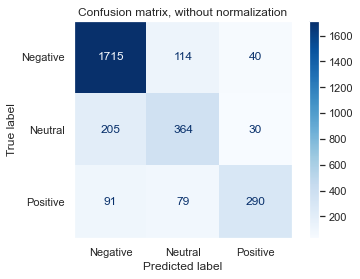

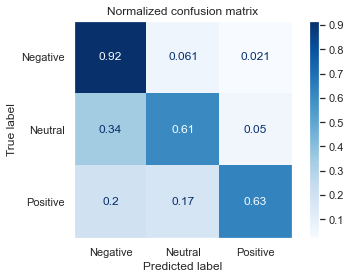

In [167]:
build_confusion_matrix(model_svm, X_test2['text'], X_test2['airline_sentiment'])

# Logistic Regression

In [171]:
pipeline = Pipeline([('vect', CountVectorizer()),
               ('xgb', LogisticRegression())])

param_test_for_search = {
    'vect__ngram_range': [(1, 3),(1, 2)],
    'vect__max_df':[0.17], 
    'vect__min_df': [0.0001]}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=10, scoring=('roc_auc_ovr','accuracy'), 
                                  cv=cv, n_jobs=-1, refit='roc_auc_ovr', random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('xgb', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'vect__max_df': [0.17],
                                        'vect__min_df': [0.0001],
                                        'vect__ngram_range': [(1, 3), (1, 2)]},
                   random_state=77, refit='roc_auc_ovr',
                   scoring=('roc_auc_ovr', 'accuracy'), verbose=2)

In [172]:
print(hyper_search.best_params_ )
print(hyper_search.best_score_)

{'vect__ngram_range': (1, 2), 'vect__min_df': 0.0001, 'vect__max_df': 0.17}
0.9111989194226846


In [174]:
model_lr = hyper_search.best_estimator_ 

In [176]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

cv_pred = cross_validate(model_lr, X_train2['text'],
                            X_train2['airline_sentiment'],
                            cv=cv, scoring=('roc_auc_ovr', 'accuracy'))

print('LR: \n', 'Accuracy =', cv_pred['test_accuracy'].mean(),
      '\n', 'Roc-Auc = ', cv_pred['test_roc_auc_ovr'].mean(), '\n') 

LR: 
 Accuracy = 0.802681826018086 
 Roc-Auc =  0.9111987952198287 



In [177]:
y_pred_prob_lr = model_lr.predict_proba(X_test2['text'])

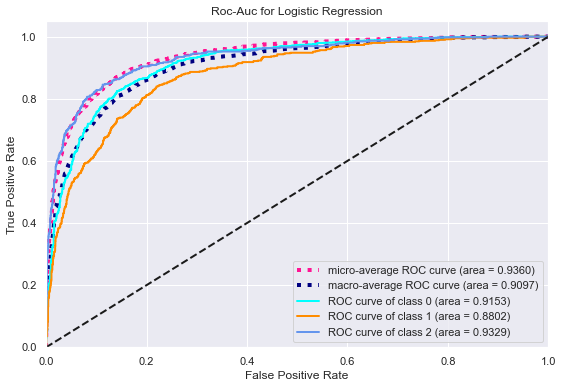

In [178]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_lr, 'Logistic Regression', 'plot')

In [179]:
y_pred_lr = model_lr.predict(X_test2['text'])
accuracy_score(X_test2['airline_sentiment'], y_pred_lr)

0.8080601092896175

Confusion matrix, without normalization
[[1679  145   45]
 [ 174  367   58]
 [  79   61  320]]
Normalized confusion matrix
[[0.9  0.08 0.02]
 [0.29 0.61 0.1 ]
 [0.17 0.13 0.7 ]]


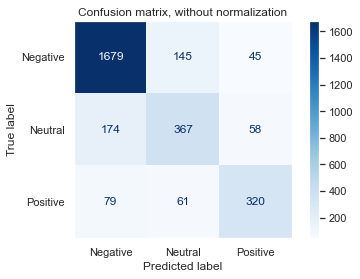

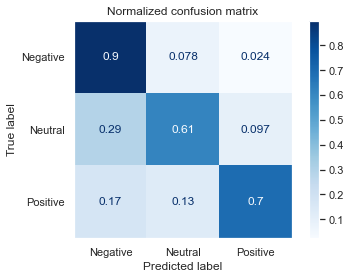

In [181]:
build_confusion_matrix(model_lr, X_test2['text'], X_test2['airline_sentiment'])

# XGBoosting Classifier

In [182]:
pipeline = Pipeline([('vect', CountVectorizer()),
               ('xgb', XGBClassifier(eval_metric = 'mlogloss'))])

param_test_for_search = {
    'vect__ngram_range': [(1, 3)],
    'vect__max_df':[0.17], 
    'vect__min_df': [0.0003],
    'xgb__n_estimators' : [380],
    #'xgb__max_depth' : [5, 6]}
    'xgb__min_child_weight' : [1],
    'xgb__gamma' : [1.0], 
    'xgb__subsample' : [0.95], 
    'xgb__colsample_bytree' : [0.55] 
        }


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=1, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='mlogloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_const

In [183]:
print(hyper_search.best_params_ ) 
print(hyper_search.best_score_)

{'xgb__subsample': 0.95, 'xgb__n_estimators': 380, 'xgb__min_child_weight': 1, 'xgb__gamma': 1.0, 'xgb__colsample_bytree': 0.55, 'vect__ngram_range': (1, 3), 'vect__min_df': 0.0003, 'vect__max_df': 0.17}
0.9100429261844043


In [184]:
model_xgb = hyper_search.best_estimator_ 

In [185]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

cv_pred = cross_validate(model_xgb, X_train2['text'],
                            X_train2['airline_sentiment'],
                            cv=cv, scoring=('roc_auc_ovr', 'accuracy'))

print('LR: \n', 'Accuracy =', cv_pred['test_accuracy'].mean(),
      '\n', 'Roc-Auc = ', cv_pred['test_roc_auc_ovr'].mean(), '\n') 

LR: 
 Accuracy = 0.8036211576318142 
 Roc-Auc =  0.9100429261844043 



In [186]:
y_pred_prob_xgb = model_xgb.predict_proba(X_test2['text'])

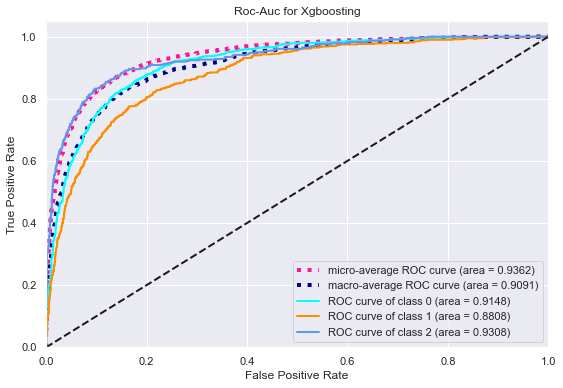

In [187]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_xgb, 'Xgboosting', 'plot')

In [188]:
y_pred_xgb = model_svm.predict(X_test2['text'])
accuracy_score(X_test2['airline_sentiment'], y_pred_xgb)

0.8090846994535519

Confusion matrix, without normalization
[[1711  109   49]
 [ 203  354   42]
 [  86   62  312]]
Normalized confusion matrix
[[0.92 0.06 0.03]
 [0.34 0.59 0.07]
 [0.19 0.13 0.68]]


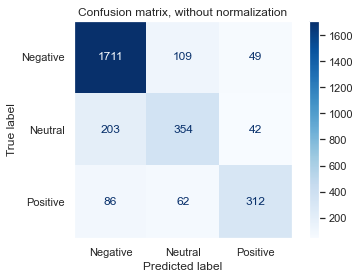

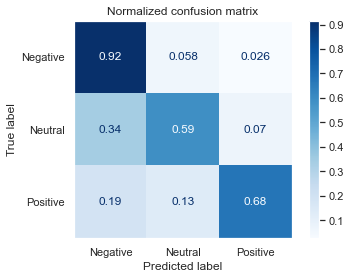

In [189]:
build_confusion_matrix(model_xgb, X_test2['text'], X_test2['airline_sentiment'])

# Random Forest

In [190]:
forest = Pipeline([('vect', CountVectorizer()),
                   ('forest', RandomForestClassifier())])

In [197]:
param_grid_base = {
    'vect__ngram_range': [(1, 2)],
    'vect__max_df':[0.17], 
    'vect__min_df':[0.0001], 
    'forest__n_estimators': [760],
    'forest__min_samples_split': [6],
    'forest__min_samples_leaf': [1],
    'forest__max_features': [32],
    'forest__max_depth': [800]
    #'forest__max_samples': [0.5, 0.45, 0.55] # Метод случайных подпространств
}

In [198]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(forest, param_grid_base, n_iter=25, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('forest',
                                              RandomForestClassifier())]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'forest__max_depth': [800],
                                        'forest__max_features': [32],
                                        'forest__min_samples_leaf': [1],
                                        'forest__min_samples_split': [6],
                                        'forest__n_estimators': [760],
                                        'vect__max_df': [0.17],
                                        'vect__min_df': [0.0001],
                                        'vect__ngram_range': [(1, 2)]},
                   random_state=77, scoring='roc_auc_ovr', verbose=2)

In [199]:
print(hyper_search.best_params_ ) 
print(hyper_search.best_score_)

{'vect__ngram_range': (1, 2), 'vect__min_df': 0.0001, 'vect__max_df': 0.17, 'forest__n_estimators': 760, 'forest__min_samples_split': 6, 'forest__min_samples_leaf': 1, 'forest__max_features': 32, 'forest__max_depth': 800}
0.9058375955597183


In [200]:
model_rf = hyper_search.best_estimator_  #0.905757

In [201]:
model_rf 

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.17, min_df=0.0001,
                                 ngram_range=(1, 2))),
                ('forest',
                 RandomForestClassifier(max_depth=800, max_features=32,
                                        min_samples_split=6,
                                        n_estimators=760))])

In [202]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

cv_pred = cross_validate(model_rf, X_train2['text'],
                            X_train2['airline_sentiment'],
                            cv=cv, scoring=('roc_auc_ovr', 'accuracy'))

print('RF: \n', 'Accuracy =', cv_pred['test_accuracy'].mean(),
      '\n', 'Roc-Auc = ', cv_pred['test_roc_auc_ovr'].mean(), '\n') 

RF: 
 Accuracy = 0.7486335553366261 
 Roc-Auc =  0.905842688468638 



In [203]:
y_pred_prob_rf = model_rf.predict_proba(X_test2['text'])

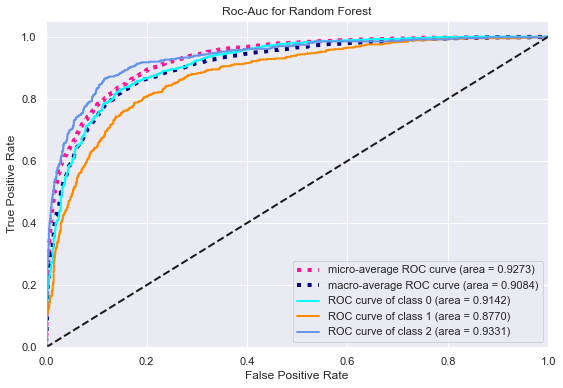

In [204]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_rf, 'Random Forest', 'plot')

In [205]:
y_pred_rf = model_rf.predict(X_test2['text'])
accuracy_score(X_test2['airline_sentiment'], y_pred_rf)

0.7848360655737705

Confusion matrix, without normalization
[[1821   36   12]
 [ 334  247   18]
 [ 185   45  230]]
Normalized confusion matrix
[[0.97 0.02 0.01]
 [0.56 0.41 0.03]
 [0.4  0.1  0.5 ]]


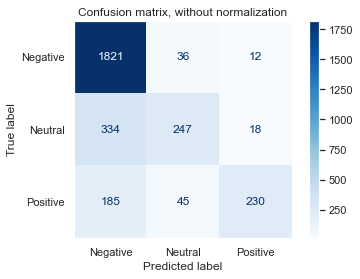

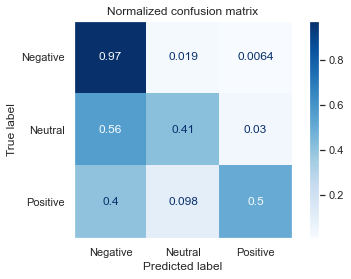

In [206]:
build_confusion_matrix(model_rf, X_test2['text'], X_test2['airline_sentiment'])

# KNN

In [207]:
mypipeknn = Pipeline([
    ('vect', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [208]:
paramknn = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'vect__max_df':[0.17], 
    'vect__min_df':[0.0001],  
    
    'knn__n_neighbors': range(2, 200, 3),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'chebyshev', 'manhattan', 'canberra'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [209]:
hyper_search = RandomizedSearchCV(mypipeknn, paramknn, n_iter=100, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(X_train2['text'], X_train2['airline_sentiment'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'knn__algorithm': ['auto', 'ball_tree',
                                                           'kd_tree', 'brute'],
                                        'knn__metric': ['minkowski',
                                                        'euclidean',
                                                        'chebyshev',
                                                        'manhattan',
                                                        'canberra'],
                                        'knn__n_neighbors': range(2, 200, 3),
                                        'knn__weights': ['uniform', 'distance'],
                                        'vect__max_df': [0

In [210]:
print(hyper_search.best_params_ ) 
print(hyper_search.best_score_)

{'vect__ngram_range': (1, 1), 'vect__min_df': 0.0001, 'vect__max_df': 0.17, 'knn__weights': 'distance', 'knn__n_neighbors': 167, 'knn__metric': 'minkowski', 'knn__algorithm': 'brute'}
0.793474473146119


In [211]:
model_knn = hyper_search.best_estimator_  

In [212]:
model_knn

Pipeline(steps=[('vect', CountVectorizer(max_df=0.17, min_df=0.0001)),
                ('knn',
                 KNeighborsClassifier(algorithm='brute', n_neighbors=167,
                                      weights='distance'))])

In [213]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

cv_pred = cross_validate(model_knn, X_train2['text'],
                            X_train2['airline_sentiment'],
                            cv=cv, scoring=('roc_auc_ovr', 'accuracy'))

print('KNN: \n', 'Accuracy =', cv_pred['test_accuracy'].mean(),
      '\n', 'Roc-Auc = ', cv_pred['test_roc_auc_ovr'].mean(), '\n') 

KNN: 
 Accuracy = 0.2774086227376421 
 Roc-Auc =  0.793474473146119 



In [214]:
y_pred_prob_knn = model_knn.predict_proba(X_test2['text'])

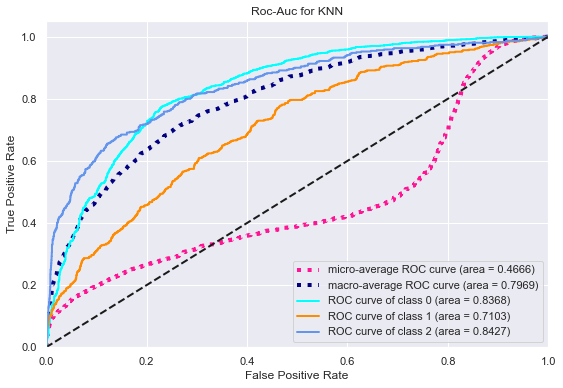

In [215]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_knn, 'KNN', 'plot')

In [216]:
y_pred_knn = model_knn.predict(X_test2['text'])
accuracy_score(X_test2['airline_sentiment'], y_pred_knn)

0.3121584699453552

Confusion matrix, without normalization
[[ 179 1202  488]
 [   3  413  183]
 [   4  134  322]]
Normalized confusion matrix
[[0.1  0.64 0.26]
 [0.01 0.69 0.31]
 [0.01 0.29 0.7 ]]


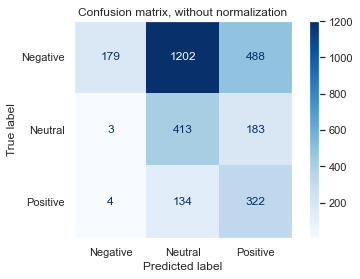

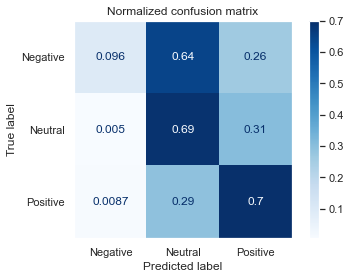

In [217]:
build_confusion_matrix(model_knn, X_test2['text'], X_test2['airline_sentiment'])

# Stacking

In [218]:
models = [model_lr, model_xgb, model_rf, model_knn, model_svm, model_nb]

# предсказания для трэйна всех моделей через кроссвалидацию
S_train_B_scratch = np.zeros((X_train2['text'].shape[0], len(models)*3))

# предсказания всех моделей для теста
S_test_B_scratch = np.zeros((X_test2['text'].shape[0], len(models)*3))

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=77)

In [219]:
for i in range(len(models)):
    for fold_counter, (tr_index, te_index) in enumerate(cv.split(X_train2['text'], X_train2['airline_sentiment'])):
            # кроссвалидация
            # tr_index - массив индексов элементов, которые попадут в трэйн, а te_index - которые попадут в тест 
            # массивы эти меняются 4 раза, так как количество фолдов = 4
            # Данные, разделенные на фолды для кроссвалидации
            X_tr = X_train2['text'][tr_index]
            y_tr = X_train2['airline_sentiment'][tr_index]
            X_te = X_train2['text'][te_index]
            y_te = X_train2['airline_sentiment'][te_index]

            _ = models[i].fit(X_tr, y_tr)

            # Запись предсказаний для трэйна 
            S_train_B_scratch[te_index, 3*i : ((3*i)+3)] = models[i].predict_proba(X_te) 

In [220]:
# Обучаемся на полном трэйне, предсказываем тест
for i in range(len(models)):
    _ = models[i].fit(X_train2['text'], X_train2['airline_sentiment'])
    S_test_B_scratch[:, 3*i : ((3*i)+3)]  = models[i].predict_proba(X_test2['text'])

# Random Forest 2 Level

In [227]:
forest = Pipeline([('forest', RandomForestClassifier())])

param_grid_base = {
    'forest__n_estimators': [170],
    'forest__min_samples_split': [31],
    'forest__min_samples_leaf': [28],
    'forest__max_features': [3],
    'forest__max_depth': [36],
    'forest__max_samples': [0.66] } 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(forest, param_grid_base, n_iter=200, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(S_train_B_scratch, X_train2['airline_sentiment'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('forest',
                                              RandomForestClassifier())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'forest__max_depth': [36],
                                        'forest__max_features': [3],
                                        'forest__max_samples': [0.66],
                                        'forest__min_samples_leaf': [28],
                                        'forest__min_samples_split': [31],
                                        'forest__n_estimators': [170]},
                   random_state=77, scoring='roc_auc_ovr', verbose=2)

In [228]:
print(hyper_search.best_params_ ) 
print(hyper_search.best_score_) 

{'forest__n_estimators': 170, 'forest__min_samples_split': 31, 'forest__min_samples_leaf': 28, 'forest__max_samples': 0.66, 'forest__max_features': 3, 'forest__max_depth': 36}
0.9180117046900325


In [229]:
model_rf2 = hyper_search.best_estimator_ 

In [231]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

cv_pred = cross_validate(model_rf2, S_train_B_scratch,
                            X_train2['airline_sentiment'],
                            cv=cv, scoring=('roc_auc_ovr', 'accuracy'))

print('Stacking: \n', 'Accuracy =', cv_pred['test_accuracy'].mean(),
      '\n', 'Roc-Auc = ', cv_pred['test_roc_auc_ovr'].mean(), '\n') 

Stacking: 
 Accuracy = 0.8137814074884835 
 Roc-Auc =  0.9179880042696531 



In [232]:
y_pred_prob_rf2 = model_rf2.predict_proba(S_test_B_scratch)

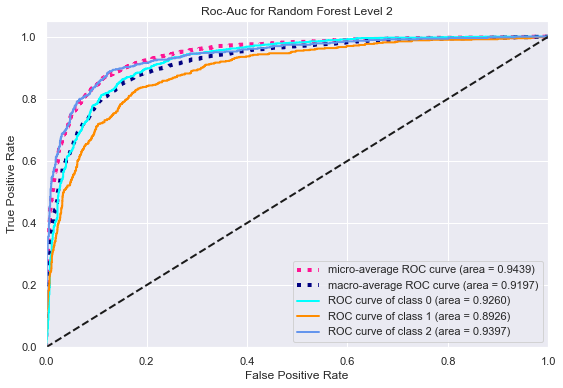

In [233]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_rf2, 'Random Forest Level 2', 'plot')

In [234]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_rf2, 'Random Forest Level 2', 'info')

Random Forest Level 2
Roc-Auc for Class 0 :  0.9260108898680371
Roc-Auc for Class 1 :  0.8926266118355267
Roc-Auc for Class 2 :  0.9397183954619126
Micro-Average :  0.9439001892412434 

Macro-Average :  0.9196955626781415


In [235]:
y_pred_rf2 = model_rf2.predict(S_test_B_scratch)
accuracy_score(X_test2['airline_sentiment'], y_pred_rf2)

0.8254781420765027

Confusion matrix, without normalization
[[1719  104   46]
 [ 181  365   53]
 [  70   57  333]]
Normalized confusion matrix
[[0.92 0.06 0.02]
 [0.3  0.61 0.09]
 [0.15 0.12 0.72]]


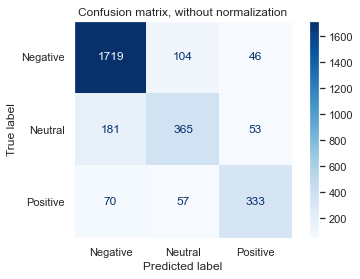

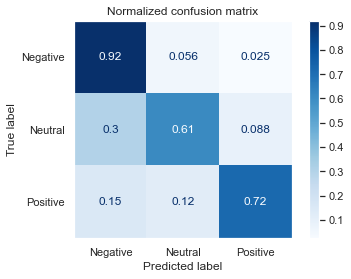

In [238]:
build_confusion_matrix(model_rf2, S_test_B_scratch, X_test2['airline_sentiment'])

---

# XGBoost 2 Level 

In [241]:
pipeline = Pipeline([
               ('xgb', XGBClassifier(eval_metric = 'mlogloss', use_label_encoder = False))])

param_test_for_search = {
    'xgb__n_estimators' : range(40, 300, 5),
    'xgb__max_depth' : range(3, 12),
    'xgb__min_child_weight' : [1, 2, 3],
    'xgb__gamma' : [1.0, 9.0, 8.0, 7.0], # [num / 10 for num in range(5, 9, 1)],
    'xgb__subsample' : [0.95, 0.9, 0.85, 0.8], #[(num + 5) / 10 for num in range(4, 6, 1)],
    'xgb__colsample_bytree' : [0.66, 0.5, 0.33, 0.75] } #[(num + 5) / 10 for num in range(0, 3, 1)]
        


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

hyper_search = RandomizedSearchCV(pipeline, param_test_for_search, n_iter=20, scoring='roc_auc_ovr', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=77,
                                  verbose=2)
hyper_search.fit(S_train_B_scratch, X_train2['airline_sentiment'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
                   estimator=Pipeline(steps=[('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='mlogloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            l

In [243]:
print(hyper_search.best_params_ ) 
print(hyper_search.best_score_) 

{'xgb__subsample': 0.95, 'xgb__n_estimators': 210, 'xgb__min_child_weight': 2, 'xgb__max_depth': 6, 'xgb__gamma': 9.0, 'xgb__colsample_bytree': 0.66}
0.917928178443532


In [1200]:
#hyper_search.cv_results_

In [244]:
model_xgb2 = hyper_search.best_estimator_ 

In [245]:
y_pred_prob_xgb2 = model_xgb2.predict_proba(S_test_B_scratch)

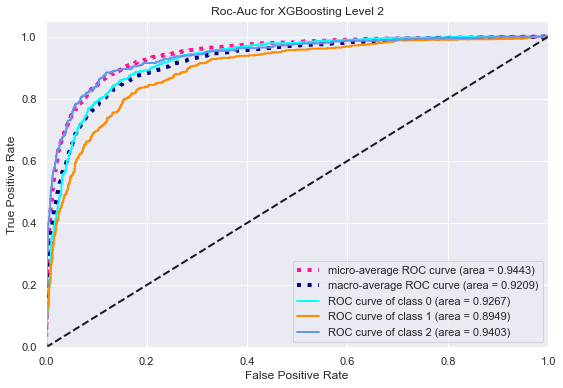

In [246]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_xgb2, 'XGBoosting Level 2', 'plot')

In [247]:
multiclass_roc_auc(X_test2['airline_sentiment'], y_pred_prob_xgb2, 'XGBoosting Level 2', 'info')

XGBoosting Level 2
Roc-Auc for Class 0 :  0.9267457563921261
Roc-Auc for Class 1 :  0.8948573226738997
Roc-Auc for Class 2 :  0.9402918222817279
Micro-Average :  0.9442945001530353 

Macro-Average :  0.9208535365801388


In [248]:
y_pred_xgb2 = model_xgb2.predict(S_test_B_scratch)
accuracy_score(X_test2['airline_sentiment'], y_pred_xgb2)

0.8220628415300546

---